In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import time
import random
import numpy as np
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import precision_score, recall_score, f1_score


ResNet152


In [9]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from PIL import Image
from timm import create_model

# check GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Dataset class
class ShapeStacksDataset(Dataset):
    def __init__(self, csv_file, img_folder, transform=None, test=False):
        self.data = pd.read_csv(csv_file)
        self.img_folder = img_folder
        self.transform = transform
        self.test = test

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_id = self.data.iloc[idx]['id']
        img_path = os.path.join(self.img_folder, f"{img_id}.jpg")
        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)

        if self.test:
            return image, img_id
        else:
            stable_height = int(self.data.iloc[idx]['stable_height']) - 1  # stable_height catorized 0~5
            return image, torch.tensor(stable_height, dtype=torch.long)  # Classification LongTensor

# image transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
}

# filepath
train_csv_path = '/content/drive/MyDrive/Colab Notebooks/COMP90086_2024_Project_train/train.csv'
test_csv_path = '/content/drive/MyDrive/Colab Notebooks/COMP90086_2024_Project_test/test.csv'
train_image_folder = '/content/drive/MyDrive/Colab Notebooks/COMP90086_2024_Project_train/train/'
test_image_folder = '/content/drive/MyDrive/Colab Notebooks/COMP90086_2024_Project_test/test/'

# load dataset
tr_ds = ShapeStacksDataset(train_csv_path, train_image_folder, transform=data_transforms['train'])

# train/validation
train_indices, val_indices = train_test_split(
    list(range(len(tr_ds))), test_size=0.2, random_state=42, stratify=tr_ds.data['stable_height'])

# train/validation indices into DataLoader
train_subset = torch.utils.data.Subset(tr_ds, train_indices)
val_subset = torch.utils.data.Subset(tr_ds, val_indices)

# train/validate DataLoader
tr_dl = DataLoader(train_subset, batch_size=8, shuffle=True, num_workers=4, pin_memory=True)
va_dl = DataLoader(val_subset, batch_size=8, shuffle=False, num_workers=4, pin_memory=True)

# ResNet152 model
class ResNetModel(nn.Module):
    def __init__(self):
        super(ResNetModel, self).__init__()
        self.resnet = create_model('resnet152', pretrained=True)  # Pre-trained ResNet152
        self.resnet.fc = nn.Linear(self.resnet.get_classifier().in_features, 6)  # stable_height classification(1~6)

    def forward(self, x):
        x = self.resnet(x)
        return x

# define model
model = ResNetModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

# StepLR scheduler (each 5 epoch, learning rate decrease x0.1)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

# train model
def train_model(model, train_loader, val_loader, scheduler, epochs=20, patience=10):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    val_precisions = []
    val_recalls = []
    val_f1_scores = []

    best_val_acc = float('-inf')
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted_classes = torch.max(outputs, 1)
            correct_train += (predicted_classes == labels).sum().item()
            total_train += labels.size(0)

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)

        # Validation Loop
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        all_labels = []
        all_predictions = []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted_classes = torch.max(outputs, 1)
                correct_val += (predicted_classes == labels).sum().item()
                total_val += labels.size(0)

                # Append labels and predictions for metrics
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted_classes.cpu().numpy())

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(correct_val / total_val)

        # Calculate precision, recall, f1-score
        val_precision = precision_score(all_labels, all_predictions, average='macro')
        val_recall = recall_score(all_labels, all_predictions, average='macro')
        val_f1 = f1_score(all_labels, all_predictions, average='macro')

        val_precisions.append(val_precision)
        val_recalls.append(val_recall)
        val_f1_scores.append(val_f1)

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, '
              f'Val Loss: {val_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, '
              f'Val Acc: {val_accuracies[-1]:.4f}, Precision: {val_precision:.4f}, '
              f'Recall: {val_recall:.4f}, F1 Score: {val_f1:.4f}')

        # Update scheduler(decreasing learning rate)
        scheduler.step()

        # Early Stopping based on F1 Score
        if val_accuracies[-1] > best_val_acc:
            best_val_acc = val_accuracies[-1]
            print(best_val_acc)
            patience_counter = 0
            torch.save(model.state_dict(), 'resnet152_stable_height.pth')  #save model
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

    return train_losses, val_losses, train_accuracies, val_accuracies, val_precisions, val_recalls, val_f1_scores

# evaluation metrix of model
train_losses, val_losses, train_accuracies, val_accuracies, val_precisions, val_recalls, val_f1_scores = train_model(model, tr_dl, va_dl, scheduler)

# save model
torch.save(model.state_dict(), 'resnet152_stable_height.pth')


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/20, Train Loss: 1.6076, Val Loss: 1.5085, Train Acc: 0.2663, Val Acc: 0.2865, Precision: 0.2211, Recall: 0.2178, F1 Score: 0.1940
0.2864583333333333
Epoch 2/20, Train Loss: 1.3887, Val Loss: 1.2849, Train Acc: 0.3831, Val Acc: 0.4297, Precision: 0.3998, Recall: 0.3766, F1 Score: 0.3532
0.4296875
Epoch 3/20, Train Loss: 1.1846, Val Loss: 1.1855, Train Acc: 0.5132, Val Acc: 0.4954, Precision: 0.4672, Recall: 0.4846, F1 Score: 0.4639
0.4954427083333333
Epoch 4/20, Train Loss: 1.0049, Val Loss: 1.1546, Train Acc: 0.6060, Val Acc: 0.5228, Precision: 0.4861, Recall: 0.5063, F1 Score: 0.4894
0.5227864583333334
Epoch 5/20, Train Loss: 0.8158, Val Loss: 1.1494, Train Acc: 0.6895, Val Acc: 0.5781, Precision: 0.5320, Recall: 0.5208, F1 Score: 0.5241
0.578125
Epoch 6/20, Train Loss: 0.5201, Val Loss: 1.1735, Train Acc: 0.8236, Val Acc: 0.5827, Precision: 0.5389, Recall: 0.5435, F1 Score: 0.5406
0.5826822916666666
Epoch 7/20, Train Loss: 0.4074, Val Loss: 1.2478, Train Acc: 0.8730, Val Acc:

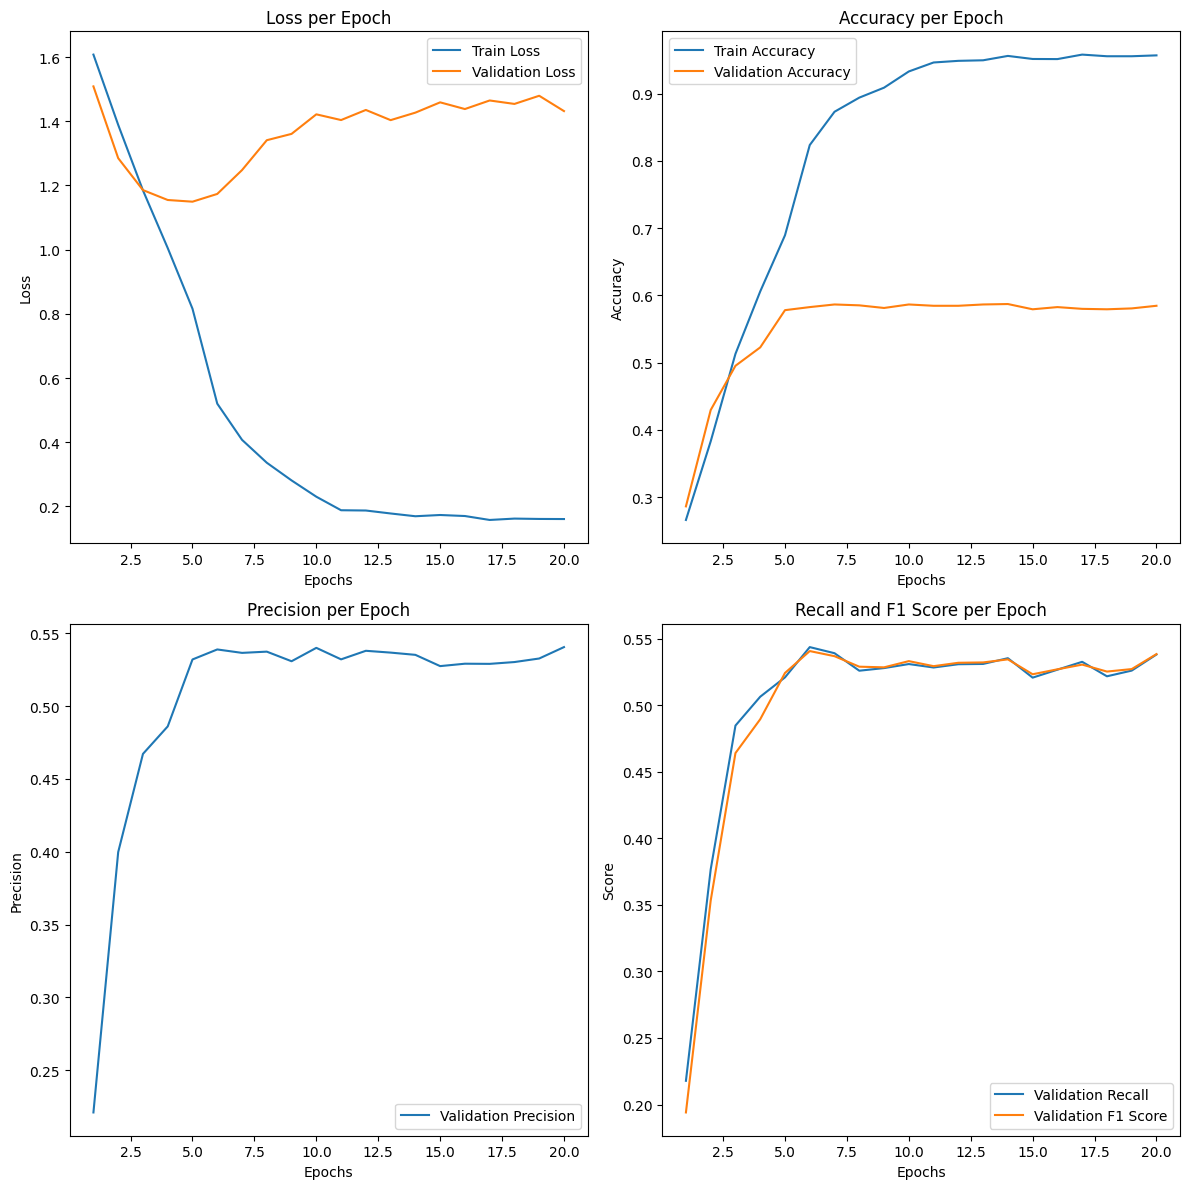

In [12]:
import matplotlib.pyplot as plt

def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, val_precisions, val_recalls, val_f1_scores):
    epochs = range(1, len(train_losses) + 1)

    # Plotting Losses
    plt.figure(figsize=(12, 12))

    plt.subplot(2, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title('Loss per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting Accuracies
    plt.subplot(2, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plotting Precision
    plt.subplot(2, 2, 3)
    plt.plot(epochs, val_precisions, label='Validation Precision')
    plt.title('Precision per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()

    # Plotting Recall and F1 Score
    plt.subplot(2, 2, 4)
    plt.plot(epochs, val_recalls, label='Validation Recall')
    plt.plot(epochs, val_f1_scores, label='Validation F1 Score')
    plt.title('Recall and F1 Score per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

# After training, call the plotting function
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, val_precisions, val_recalls, val_f1_scores)


In [10]:
# load test dataset
test_ds = ShapeStacksDataset(test_csv_path, test_image_folder, transform=data_transforms['test'], test=True)
test_dl = DataLoader(test_ds, batch_size=8, shuffle=False, num_workers=4, pin_memory=True)

# load model
model.load_state_dict(torch.load('resnet101_stable_height.pth'))
model.eval()

# prediction and export to csv file
def test_model(model, test_loader, test_csv_path):
    model.eval()
    predictions = []
    img_ids = []

    with torch.no_grad():
        for images, img_ids_batch in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted_classes = torch.max(outputs, 1)
            predictions.extend(predicted_classes.cpu().numpy())
            img_ids.extend(img_ids_batch)

    # CSV 파일에 예측된 결과 저장
    test_df = pd.read_csv(test_csv_path)
    test_df['predicted_stable_height'] = [p + 1 for p in predictions]  # stable_height (0~5) converts into (1~6)
    test_df[['id', 'predicted_stable_height']].to_csv('/content/drive/MyDrive/Colab Notebooks/resnet152_batch8_predictions.csv', index=False)
    print("saved")


test_model(model, test_dl, test_csv_path)


<ipython-input-10-2fb6ba43cfd4>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('resnet101_stable_height.pth'))


saved
